# Pre-Run Environment Setup for Google Colab

## Mount Google Drive

# Import Libraries

In [1]:
# Import neccessary libraries
import pandas as pd
import numpy as np
import os
from joblib import dump
from tqdm import tqdm
import random
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define a function to set seeds for reproducibility
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# Load Dataset

## Set Up the Path to Data Directory

In [3]:
import os
base_path = '../Dataset/MRNet-v1.0'

In [4]:
# Define function to load data and summarise labels
def load_data(label_type: str, data_split: str):
    """
    Loads a label CSV file and renames its columns for clarity.

    Args:
        label_type (str): one of ["abnormal", "acl", "meniscus"]
        data_split (str): "train" or "valid"
    Returns:
        pd.DataFrame: processed dataframe with columns ["Series", label_type]
    """
    filename = f"{data_split}-{label_type}.csv"
    df = pd.read_csv(os.path.join(base_path, filename), header=None)
    df.columns = ["Series", label_type]

    # Pad Series column with leading zeros to 4 digits
    df["Series"] = df["Series"].astype(str).str.zfill(4)

    return df

In [5]:
# Load and merge all three training label files
df_train_abnormal = load_data("abnormal", "train")
df_train_acl = load_data("acl", "train")
df_train_meniscus = load_data("meniscus", "train")

# Load and merge all three validation label files
df_valid_abnormal = load_data("abnormal", "valid")
df_valid_acl = load_data("acl", "valid")
df_valid_meniscus = load_data("meniscus", "valid")

# Exploratory Data Analysis

## Data Summary

In [6]:
# Merge into one training dataframe
df_train = df_train_abnormal.merge(df_train_acl, on="Series").merge(df_train_meniscus, on="Series")

# Merge into one validation dataframe
df_valid = df_valid_abnormal.merge(df_valid_acl, on="Series").merge(df_valid_meniscus, on="Series")

In [7]:
df_train

,Series,abnormal,acl,meniscus
0,0000,1,0,0
1,0001,1,1,1
2,0002,1,0,0
3,0003,1,0,1
4,0004,1,0,0
...,...,...,...,...
1125,1125,1,0,1
1126,1126,1,0,1
1127,1127,0,0,0
1128,1128,1,0,0


In [8]:
# Summarise training and validation data
print("Total Training Data:", len(df_train))
print("Total Validation Data:", len(df_valid))

Total Training Data: 1130
Total Validation Data: 120


## Label Distribution

In [9]:
# Define function to print summary table
def get_label_distribution(df_combined: pd.DataFrame, title: str):
    """
    Calculates and prints a summary of the label distribution.
    """
    label_counts = {
        "Abnormal": df_combined["abnormal"].value_counts().rename(index={0: "Negative", 1: "Positive"}),
        "ACL Tear": df_combined["acl"].value_counts().rename(index={0: "Negative", 1: "Positive"}),
        "Meniscus Tear": df_combined["meniscus"].value_counts().rename(index={0: "Negative", 1: "Positive"})
    }

    summary_df = pd.DataFrame(label_counts).T[["Negative", "Positive"]]
    print(f"\nLabel Summary - {title}")
    print(summary_df)

    return summary_df

In [10]:
# Summarise training labels
train_summary = get_label_distribution(df_train, title="Training Set")
valid_summary = get_label_distribution(df_valid, title="Validation Set")


Label Summary - Training Set
               Negative  Positive
Abnormal            217       913
ACL Tear            922       208
Meniscus Tear       733       397

Label Summary - Validation Set
               Negative  Positive
Abnormal             25        95
ACL Tear             66        54
Meniscus Tear        68        52


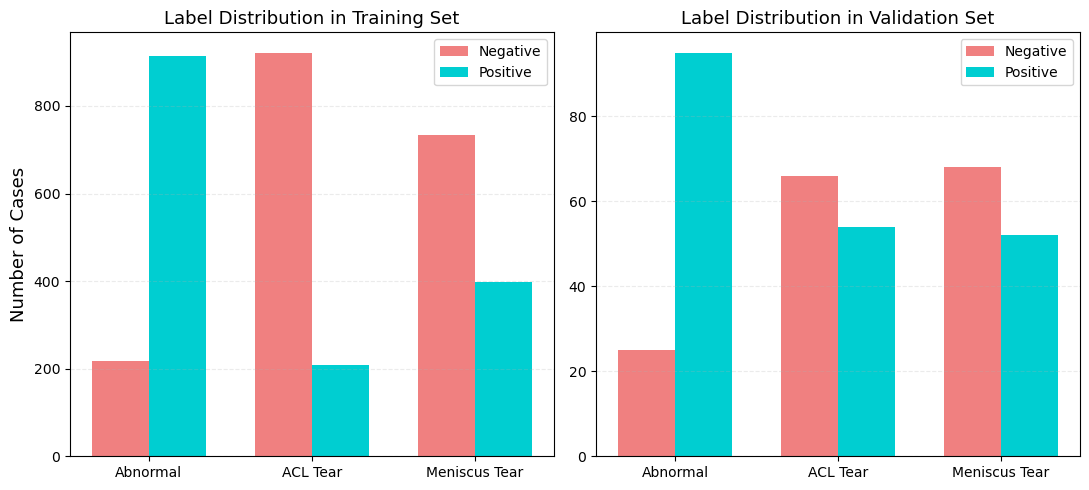

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

x = np.arange(len(train_summary.index)) # 3 categories
width = 0.35  # width of each bar

# Label distribution of training set
ax[0].bar(x - width/2, train_summary["Negative"], width, label='Negative', color='lightcoral')
ax[0].bar(x + width/2, train_summary["Positive"], width, label='Positive', color='darkturquoise')
ax[0].set_title("Label Distribution in Training Set", fontsize=13)
ax[0].set_xticks(x)
ax[0].set_xticklabels(train_summary.index)
ax[0].set_ylabel("Number of Cases", fontsize=13)
ax[0].legend()
ax[0].grid(axis='y', linestyle='--', alpha=0.25)

# Label distribution of validation set
ax[1].bar(x - width/2, valid_summary["Negative"], width, label='Negative', color='lightcoral')
ax[1].bar(x + width/2, valid_summary["Positive"], width, label='Positive', color='darkturquoise')
ax[1].set_title("Label Distribution in Validation Set", fontsize=13)
ax[1].set_xticks(x)
ax[1].set_xticklabels(valid_summary.index)
ax[1].legend()
ax[1].grid(axis='y', linestyle='--', alpha=0.25)

plt.tight_layout()
plt.show()

## Slice Count Distribution

In [12]:
# Define folder names to the scan files (.npy files)
splits = ["train", "valid"]
views = ["sagittal", "coronal", "axial"]

In [13]:
slice_counts = {} # Dictionary to store slice counts for each (split, view)

# Collect slice counts
for split in splits:
    for view in views:
        path = os.path.join(base_path, split, view)
        count_list = []

        if not os.path.exists(path): # Check if the directory exists to avoid runtime errors
            print(f"Directory not found: {path}")
            continue

        for file in tqdm(os.listdir(path), desc=f"Processing {split}/{view}", unit="file"):
            if file.endswith(".npy"):
                try:
                    vol = np.load(os.path.join(path, file)) # Load the 3D volume
                    count_list.append(vol.shape[0]) # Record the number of slices
                except Exception as e:
                    print(f"Error reading {file} in {split}/{view}: {e}")

        slice_counts[(split, view)] = count_list

# Save the slice_counts dictionary
dump(slice_counts, "slice_counts.joblib")
print("\nslice_counts saved to 'slice_counts.joblib'")

Processing valid/axial: 100%|██████████████| 120/120 [00:00<00:00, 843.31file/s]


slice_counts saved to 'slice_counts.joblib'


In [14]:
for split in splits:
    for view in views:
        key = (split, view)

        if key in slice_counts:
            counts = slice_counts[key]
            print(f"{split.capitalize()} - {view.capitalize()}")
            print(f"Total scans: {len(counts)}")
            print(f"Min slices: {min(counts) if counts else 'N/A'}")
            print(f"Max slices: {max(counts) if counts else 'N/A'}")
            print(f"Mean slices: {np.mean(counts):.2f}" if counts else "No data")
            print(f"Std Dev: {np.std(counts):.2f}\n" if counts else "No data")
        else:
            print(f"\nNo data for {split}/{view}")

Train - Sagittal
Total scans: 1130
Min slices: 17
Max slices: 51
Mean slices: 30.42
Std Dev: 6.96

Train - Coronal
Total scans: 1130
Min slices: 17
Max slices: 58
Mean slices: 29.78
Std Dev: 8.71

Train - Axial
Total scans: 1130
Min slices: 19
Max slices: 61
Mean slices: 34.32
Std Dev: 7.54

Valid - Sagittal
Total scans: 120
Min slices: 21
Max slices: 45
Mean slices: 30.52
Std Dev: 6.35

Valid - Coronal
Total scans: 120
Min slices: 17
Max slices: 48
Mean slices: 29.43
Std Dev: 8.35

Valid - Axial
Total scans: 120
Min slices: 20
Max slices: 52
Mean slices: 34.32
Std Dev: 7.13



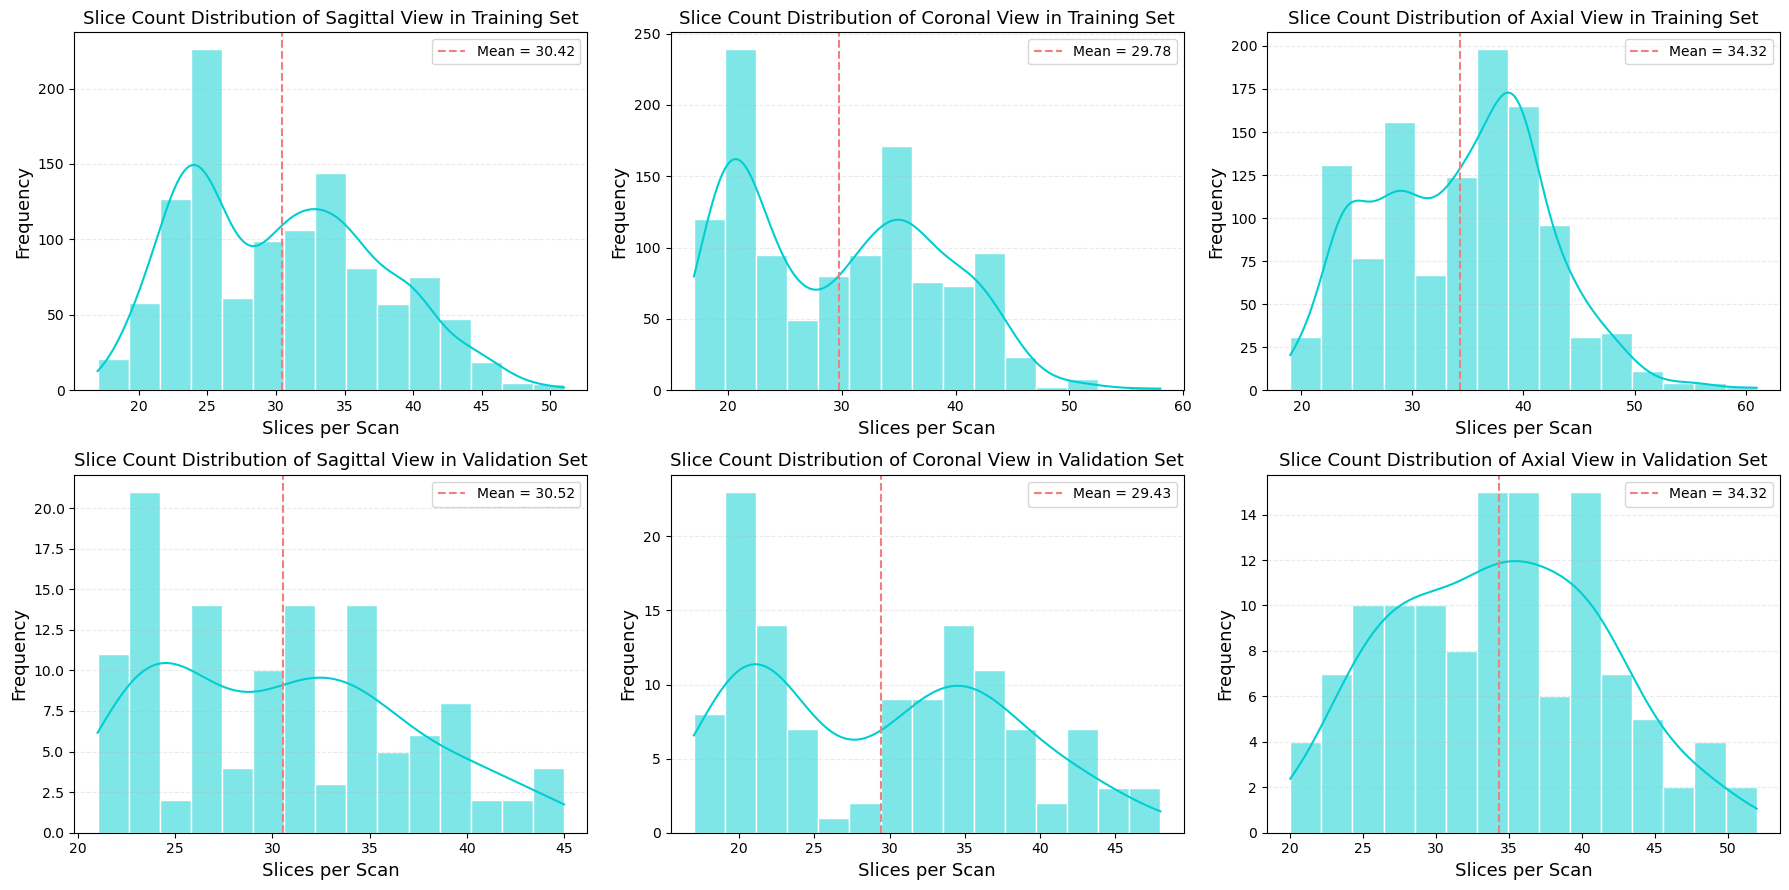

In [15]:
fig, axs = plt.subplots(len(splits), len(views), figsize=(18, 9))

# Define mapping from split to full name
split_names = {"train": "Training", "valid": "Validation"}

for i, split in enumerate(splits):
    for j, view in enumerate(views):
        key = (split, view)
        counts = slice_counts[key]
        ax = axs[i, j]

        # Plot histogram
        sns.histplot(counts, bins=15, color='darkturquoise', edgecolor='white', kde=True, ax=ax)

        # Compute stats
        mean_val = np.mean(counts)
        std_val = np.std(counts)

        # Plot vertical line for mean
        ax.axvline(mean_val, color='lightcoral', linestyle='--', label=f"Mean = {mean_val:.2f}")

        # Titles and labels
        ax.set_title(f"Slice Count Distribution of {view.capitalize()} View in {split_names[split]} Set", fontsize=13)
        ax.set_xlabel("Slices per Scan", fontsize=13)
        ax.set_ylabel("Frequency", fontsize=13)
        ax.legend(fontsize=10)
        ax.grid(axis='y', linestyle='--', alpha=0.25)

plt.tight_layout()
plt.show()

## Visualising Sample Slices from All Views

In [16]:
# Configuration
split = splits[0] # train
labels = ["acl", "meniscus", "abnormal"]

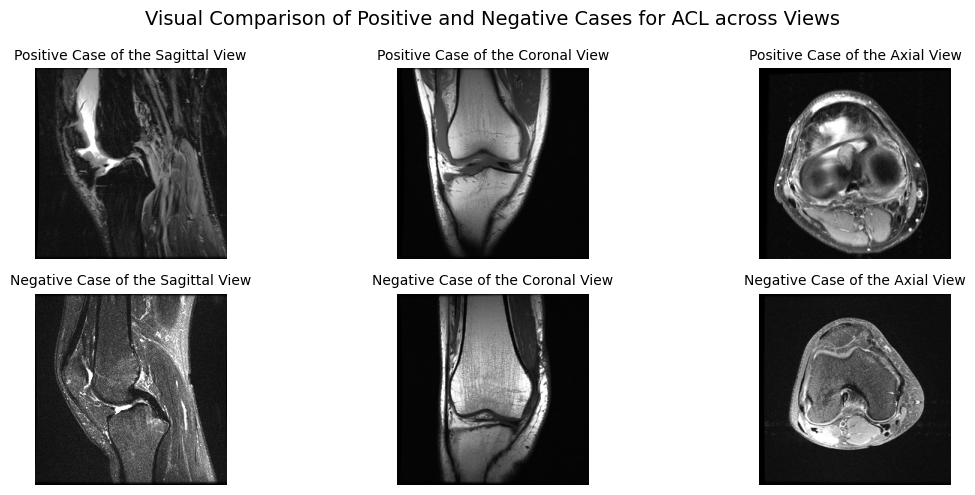

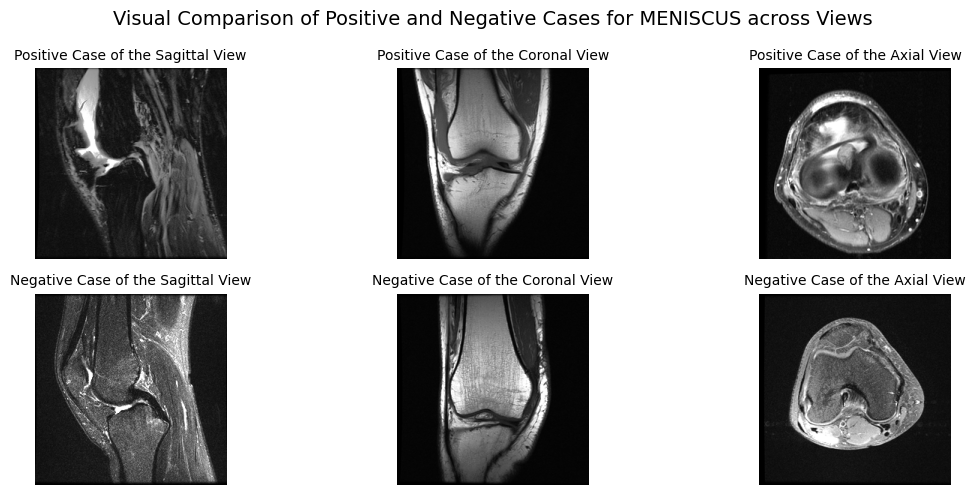

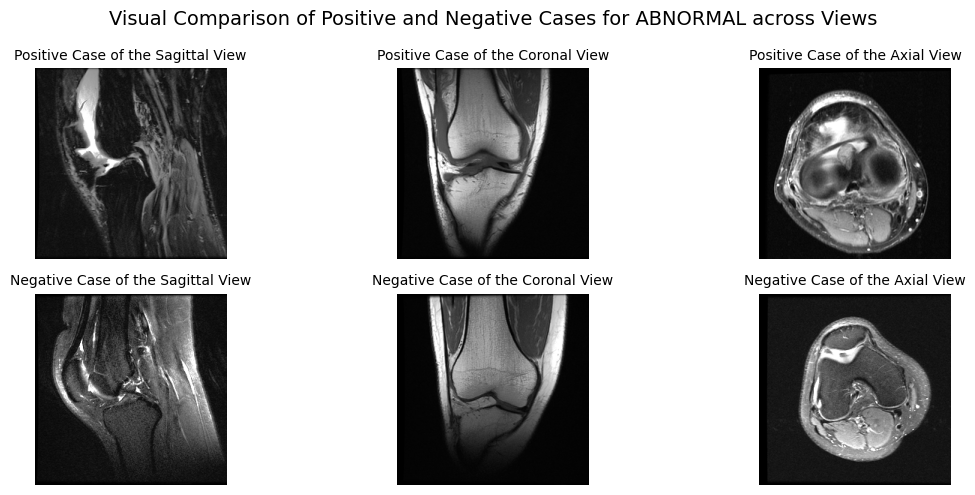

In [17]:
for label in labels:

    # Load label CSV
    label_path = os.path.join(base_path, f"{split}-{label}.csv")
    df = pd.read_csv(label_path)
    df.columns = ['Series', label]
    df['Series'] = df['Series'].astype(str).str.zfill(4)

    # Select one positive and one negative example
    pos_id = df[df[label] == 1]['Series'].iloc[0]
    neg_id = df[df[label] == 0]['Series'].iloc[0]

    # Setup figure for this label
    fig, axs = plt.subplots(2, 3, figsize=(12, 5))

    for j, view in enumerate(views):

        # Load positive case
        pos_path = os.path.join(base_path, split, view, f"{pos_id}.npy")
        pos_vol = np.load(pos_path)
        pos_slice = pos_vol[pos_vol.shape[0] // 2]

        # Load negative case
        neg_path = os.path.join(base_path, split, view, f"{neg_id}.npy")
        neg_vol = np.load(neg_path)
        neg_slice = neg_vol[neg_vol.shape[0] // 2]

        # Plot positive slice
        axs[0, j].imshow(pos_slice, cmap='gray')
        axs[0, j].axis('off')
        axs[0, j].set_title(f"Positive Case of the {view.capitalize()} View", fontsize=10)

        # Plot negative slice
        axs[1, j].imshow(neg_slice, cmap='gray')
        axs[1, j].axis('off')
        axs[1, j].set_title(f"Negative Case of the {view.capitalize()} View", fontsize=10)

    # Title and layout
    plt.suptitle(f"Visual Comparison of Positive and Negative Cases for {label.upper()} across Views", fontsize=14)
    plt.tight_layout()
    plt.show()


## Co-occurrence of Labels
Checking how often multiple labels are positive in the same MRI scan.

In [18]:
# Co-occurrence in training set
df_train['positive_counts'] = df_train[['abnormal', 'acl', 'meniscus']].sum(axis=1)
co_occur_train = df_train['positive_counts'].value_counts().sort_index()

# Co-occurrence in validation set
df_valid['positive_counts'] = df_valid[['abnormal', 'acl', 'meniscus']].sum(axis=1)
co_occur_valid = df_valid['positive_counts'].value_counts().sort_index()

In [19]:
# Combine into a single DataFrame
df_co_occur = pd.DataFrame({'Training': co_occur_train, 'Validation': co_occur_valid}).astype(int)

# Print table
print(df_co_occur)

                 Training  Validation
positive_counts                      
0                     217          25
1                     433          20
2                     355          44
3                     125          31


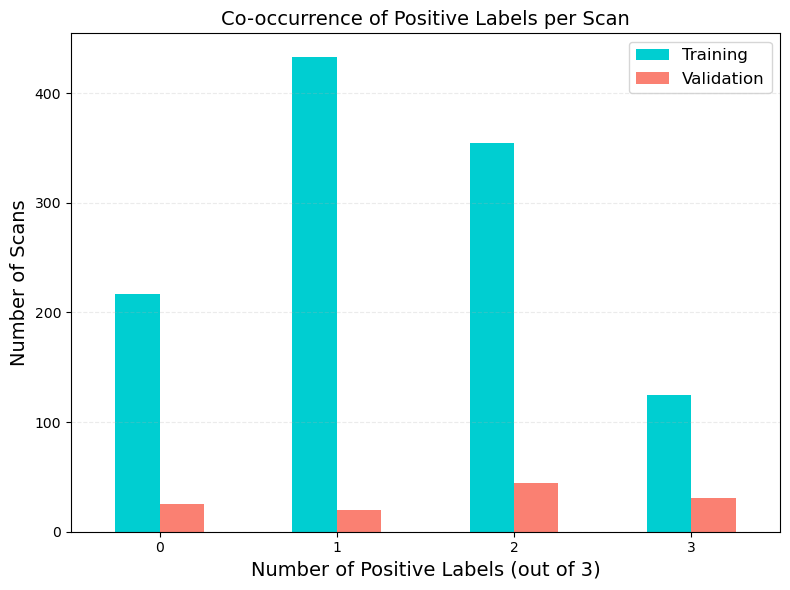

In [20]:
df_co_occur.plot(kind='bar', figsize=(8, 6), color=['darkturquoise', 'salmon'])
plt.title("Co-occurrence of Positive Labels per Scan", fontsize=14)
plt.xlabel("Number of Positive Labels (out of 3)", fontsize=14)
plt.ylabel("Number of Scans", fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.25)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Data Augmentation and Data Loader
~~~~#%% md
~~~~## Import Libraries

In [21]:
# Import and reload neccessary libraries
import sys 
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import importlib
# importlib.reload(Dataloader.utils.dataset)
# importlib.reload(Dataloader.utils.transforms)

sys.path.append("..") 
from Dataloader.utils.dataset import MRNetDataset
from Dataloader.utils.transforms import get_mrnet_train_transforms, get_mrnet_valid_transforms

In [22]:
# Set seed for reproducibility
set_seed()

In [23]:
# Define transform pipelines for training and validation
train_transform = get_mrnet_train_transforms(target_slices=32)
valid_transform = get_mrnet_valid_transforms(target_slices=32)

In [24]:
# Create training dataset
train_dataset = MRNetDataset(
    data_dir=os.path.join(base_path, "train"),
    df_labels=df_train,
    transform=train_transform
)

# Create validation dataset
valid_dataset = MRNetDataset(
    data_dir=os.path.join(base_path, "valid"),
    df_labels=df_valid,
    transform=valid_transform
)

In [25]:
# Create DataLoader for training
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Create DataLoader for validation
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)

## Visualise Augmented Sample Slice from Train Set

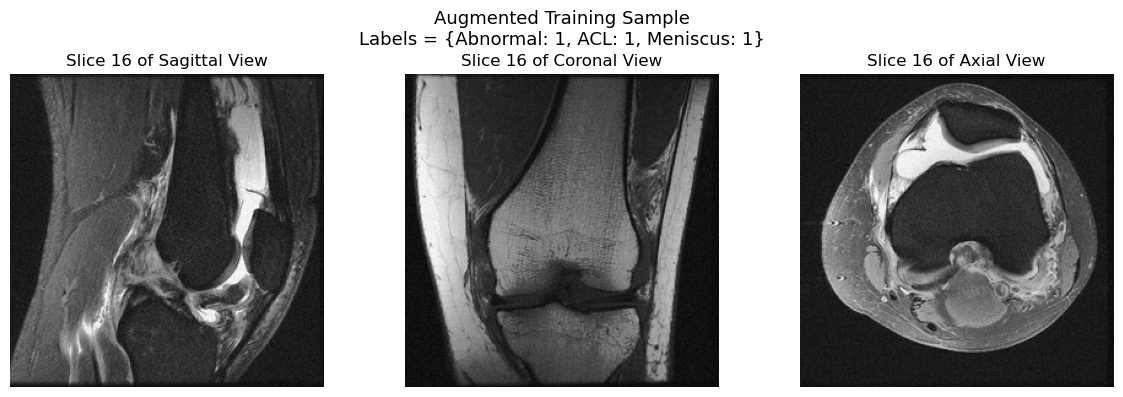

In [26]:
# Only gets the first batch of training data
x_batch, y_batch = next(iter(train_loader)) # Loader is train_loader

# Select the second sample
sample_idx = 0
x_sample = x_batch[sample_idx] # Shape: [views, slices, H, W]
y_sample = y_batch[sample_idx]

views = ['Sagittal', 'Coronal', 'Axial']
slice_idx = x_sample.shape[1]//2 # Middle slice

# Plot the selected slice from each view
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    axs[i].imshow(x_sample[i, slice_idx].numpy(), cmap='gray')
    axs[i].set_title(f"Slice {slice_idx} of {views[i]} View", fontsize=12)
    axs[i].axis('off')

# Format label as dictionary-style string
label_dict_str = f"{{Abnormal: {int(y_sample[0])}, ACL: {int(y_sample[1])}, Meniscus: {int(y_sample[2])}}}"

plt.suptitle(f"Augmented Training Sample\nLabels = {label_dict_str}", fontsize=13)
plt.tight_layout()
plt.show()

# Loading Model

In [27]:
# from torchvision.models.video import r3d_18
# import torch.nn as nn

# model = r3d_18(pretrained=True)
# model.stem[0] = nn.Conv3d(3, 64, kernel_size=(3,7,7), stride=(1,2,2), padding=(1,3,3), bias=False)
# model.fc = nn.Linear(model.fc.in_features, 3)  # 3 outputs for multi-label

In [28]:
x, y = next(iter(train_loader))

print("x shape:", x.shape)
print("y shape:", y.shape)
print("x dtype:", x.dtype)
print("y dtype:", y.dtype)
print("y sample:", y[0])

x shape: torch.Size([4, 3, 32, 256, 256])
y shape: torch.Size([4, 3])
x dtype: torch.float32
y dtype: torch.float32
y sample: tensor([0., 0., 0.])


# Training Loop

In [29]:
from Model import AlexNet

model = AlexNet.AlexNetSlice()

/opt/anaconda3/envs/ml/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/ml/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from Model.utils.checkpoint import save_checkpoint, load_checkpoint
import os

# ==== Configuration ====
num_epochs = 50
patience = 5
checkpoint_dir = 'alexnet_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
start_epoch = 0

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = model.to(device)

if device.type == 'mps':
    print("Device is MPS")

# ==== Optimizer, loss, scheduler ====
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

# ==== Metric trackers ====
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

# ==== Resume from checkpoint if available ====
last_ckpt_path = os.path.join(checkpoint_dir, 'last_checkpoint.pth')
if os.path.exists(last_ckpt_path):
    start_epoch, _ = load_checkpoint(
        last_ckpt_path, model, optimizer, scheduler, map_location=device
    )
    print(f"🔁 Resumed training from epoch {start_epoch + 1}")

# ==== Training Loop ====
for epoch in range(start_epoch, num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    print("Training starts")

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)

        preds = (torch.sigmoid(outputs) > 0.5).float()
        train_correct += (preds == y).float().mean().item()
        train_total += 1

    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / train_total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # ==== Validation ====
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for x_val, y_val in valid_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_outputs = model(x_val)
            val_loss += criterion(val_outputs, y_val).item() * x_val.size(0)

            preds_val = (torch.sigmoid(val_outputs) > 0.5).float()
            val_correct += (preds_val == y_val).float().mean().item()
            val_total += 1

    val_loss /= len(valid_loader.dataset)
    val_acc = val_correct / val_total
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Learning rate: {scheduler.get_last_lr()[0]:.6f}")

    # ✅ Save checkpoint after every epoch
    ckpt_path = os.path.join(checkpoint_dir, f'epoch_{epoch+1:02d}.pth')
    save_checkpoint(ckpt_path, model, optimizer, scheduler, epoch, val_loss)
    save_checkpoint(last_ckpt_path, model, optimizer, scheduler, epoch, val_loss)
    print(f"📦 Checkpoint saved at {ckpt_path}")

    if scheduler.num_bad_epochs >= patience:
        print("⏹️ Early stopping triggered due to no improvement.")
        break


Device is MPS
Training starts
Epoch 1/50 | Train Loss: 0.5376 | Val Loss: 0.7170
Train Acc: 0.7527 | Val Acc: 0.6444
Learning rate: 0.000100
Checkpoint saved to alexnet_checkpoints/epoch_01.pth
Checkpoint saved to alexnet_checkpoints/last_checkpoint.pth
📦 Checkpoint saved at alexnet_checkpoints/epoch_01.pth
Training starts
Epoch 2/50 | Train Loss: 0.5015 | Val Loss: 0.5930
Train Acc: 0.7635 | Val Acc: 0.6667
Learning rate: 0.000100
Checkpoint saved to alexnet_checkpoints/epoch_02.pth
Checkpoint saved to alexnet_checkpoints/last_checkpoint.pth
📦 Checkpoint saved at alexnet_checkpoints/epoch_02.pth
Training starts
Epoch 3/50 | Train Loss: 0.4693 | Val Loss: 0.6206
Train Acc: 0.7703 | Val Acc: 0.6583
Learning rate: 0.000100
Checkpoint saved to alexnet_checkpoints/epoch_03.pth
Checkpoint saved to alexnet_checkpoints/last_checkpoint.pth
📦 Checkpoint saved at alexnet_checkpoints/epoch_03.pth
Training starts
Epoch 4/50 | Train Loss: 0.4485 | Val Loss: 0.6707
Train Acc: 0.7739 | Val Acc: 0.661

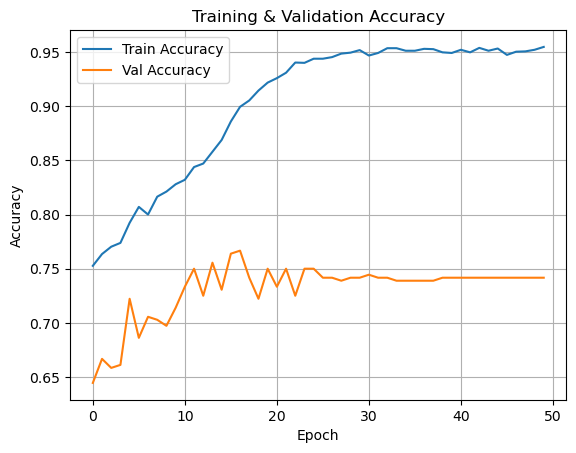

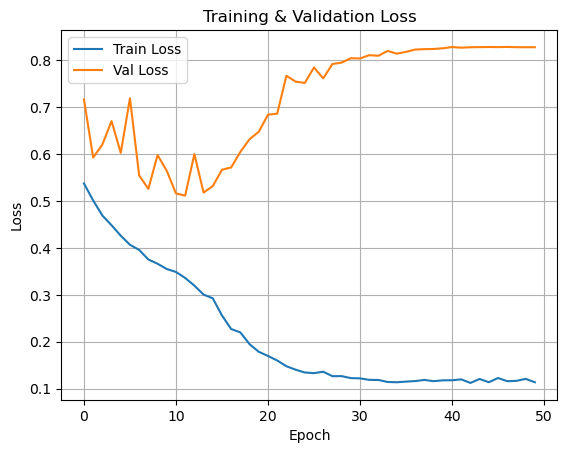

In [31]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

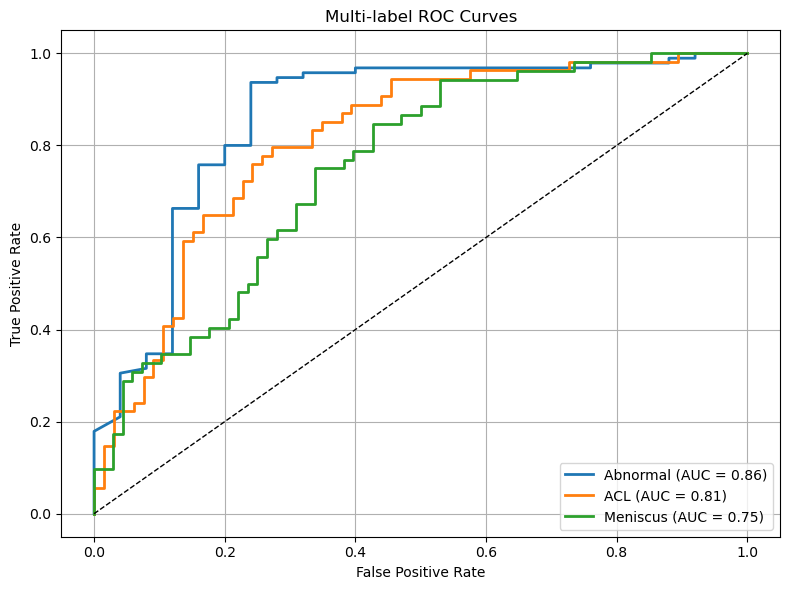

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import os

# Put model in evaluation mode
model.eval()

# Gather predictions and ground truths
all_preds = []
all_targets = []

with torch.no_grad():
    for x, y in valid_loader:
        x = x.to(device)
        y = y.to(device)
        probs = torch.sigmoid(model(x)).cpu().numpy()
        all_preds.append(probs)
        all_targets.append(y.cpu().numpy())

# Stack all batches
y_score = np.vstack(all_preds)  # shape: (N, 3)
y_true = np.vstack(all_targets) # shape: (N, 3)

# Class names
class_names = ["Abnormal", "ACL", "Meniscus"]

# Create figs directory
os.makedirs("figs", exist_ok=True)

# ==== Plot ROC Curves ====
plt.figure(figsize=(8, 6))
for i in range(3):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-label ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("figs/roc_curve.png", dpi=300)
plt.show()

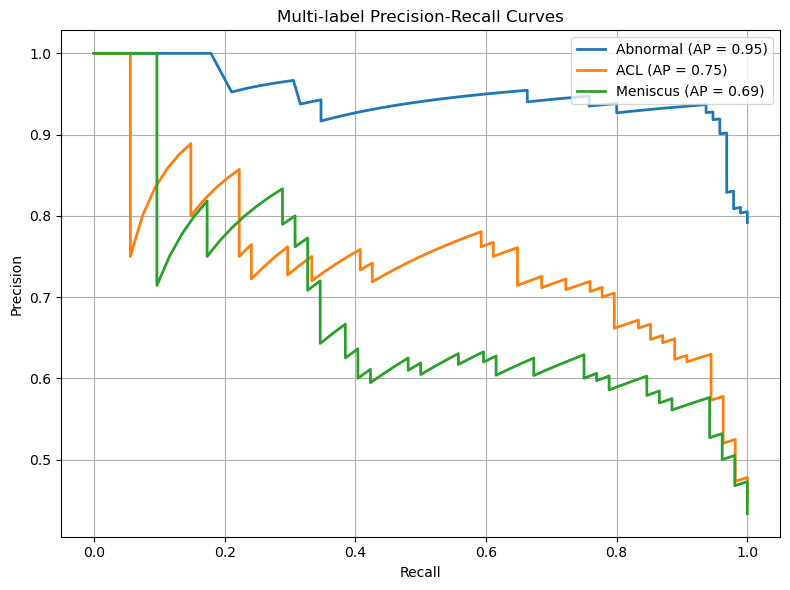

In [33]:
plt.figure(figsize=(8, 6))
for i in range(3):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_score[:, i])
    ap = average_precision_score(y_true[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f'{class_names[i]} (AP = {ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-label Precision-Recall Curves')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig("figs/pr_curve.png", dpi=300)
plt.show()
